# ENTRENAMIENTO MODELO IA / ¿SPAM o NO SPAM?

>En esta ocasión, estaremos entrenando un modelo de IA capaz de detectar cuando un correo es o no es SPAM, usaremos temporalmente un dataset en formato CSV pequeño para ver su comportamiento y utilizando por primera vez tecnologías como:
>Jupyter
>Pandas
>Matplot
>Sklearn
>Pytorch


---

## Paso 1 – Cargar los datos

En esta sección vamos a cargar el CSV con pandas para inspeccionar el dataset.

---

In [1]:
import pandas as pd

#Cargar el CSV con el dataset
df = pd.read_csv("data/spam_dataset.csv")

#Mostrar las primeras filas
df.head()

,text,label
0,Free money now!!!,spam
1,"Hi, how are you?",ham
2,Win a brand new car,spam
3,Are we still on for lunch?,ham
4,Call now to claim your prize,spam


---

## Paso 2 - Convertir 'spam' y 'ham' en 1's y 0's respectivamente
Lo haremos para el entrenamiento del modelo y para ayudarnos para vectorizar nuestro dataset

---

In [2]:
#Convertir etiquetas a números
df['label'] = df['label'].map({'ham' : 0, 'spam' : 1})

#Verificamos que se haya conseguido correctamente
df.head()

,text,label
0,Free money now!!!,1
1,"Hi, how are you?",0
2,Win a brand new car,1
3,Are we still on for lunch?,0
4,Call now to claim your prize,1


---

## Paso 3 - Separamos los nombres de las etiquetas
Tendremos mayor orden y control sobre los datos

---

In [3]:
X = df['text'] #Los mensajes
y = df['label'] #Etiquetas (0,1)

---

## Paso 4 - Dividiremos el dataset en training set (80%) y testing set (20%) 
Esto para probar que el modelo tenga ejemplos para referenciarse y luego probar la detección con otros ejemplos que no haya visto nunca. En caso que utilicemos datos de más y el modelo solo esté memorizando. Obtendremos un problema comúnmente conocido como **Overfitting**.

Para poder dividir el dataset utilizaremos ```train_test_split```

---

In [4]:
from sklearn.model_selection import train_test_split

#Dividimos el dataset en las proporciones mencionadas
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

**Nota**: El ```random_state=42``` significa: “Usá esta semilla aleatoria fija para que la división entre train y test sea siempre igual cada vez que ejecuto el código.”

Esto es así puesto que si no lo colocamos, cada vez que se corra el código, los datos se **dividen distinto**, porque el proceso es aleatorio.
Eso hace que los resultados cambien y sean difíciles de reproducir.

---

## Paso 5 - Vectorizar los mensajes
**Pytorch** por defecto no entiende textos, solo **Tensores**, una estructura matemática que hace todo posible en la Inteligencia Artifical. Asi que utilizaremos Scikit Learn para poder vectorizar la información y prepararla para poder llevarla a Tensores

---

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

#Creando el vectorizador
vectorizer = CountVectorizer()

#Aprender a partir de texto y pasarlo a vectores
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

### ¿Qué hace esto?

Crea una "bolsa de palabras": cada palabra es una columna.

Cada mensaje se transforma en un vector que cuenta cuántas veces aparece cada palabra.

El resultado es una matriz dispersa (sparse matrix) como esta:

```[0 1 0 0 3 0 0 2 ...]```

Cada número representa la **frecuencia** de una palabra en ese mensaje.

---

## Paso 6 - Conversión Tensorial y preparar el dataLoader
Una vez vectorizado el dataset, podemos pasarlos a tensores para trabajar con pytorch sin problemas, además de agregar el **dataLoader**, cuyo funcionamiento es cargar automáticamente los datos a Pytorch, sin necesidad de ir uno por uno.

- Este proceso consiste en dividir en lotes (batchs) equitativos de datos:


  Ejemplo: Si tenemos un dataset de 800 elementos, y el lote es de 16 datos cada uno, tendremos 50 lotes, 16x50 = 800.

  
- Permite hacer **shuffle**, es decir, mezclar los datos para que no sea siempre lo mismo.

- Y también nos facilita el trabajo con datasets grandes, para no saturar la memoria, podemos ir pasando por lotes.

---

In [6]:
import torch
from torch.utils.data import TensorDataset, DataLoader

#Convertimos todos los vectores en Tensores y los pasamos como flotantes
X_train_tensor = torch.tensor(X_train_vect.toarray()).float()
X_test_tensor = torch.tensor(X_test_vect.toarray()).float()
y_train_tensor = torch.tensor(y_train.values).float()
y_test_tensor = torch.tensor(y_test.values).float()

# Dataset y DataLoader
BATCH_SIZE = 16

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

**Nota:**

```.toarray()``` convierte la matriz dispersa en una común para que PyTorch pueda leerla

```float()``` es porque vamos a usar redes neuronales que trabajan con números reales

```TensorDataset``` empaqueta entradas y etiquetas

```DataLoader``` reparte los datos en mini-lotes (batches) y los mezcla (shuffle)

---

## Paso 7 - Crear el Modelo con Pytorch
Crearemos en esta ocasión una red neuronal de Clasificación Binaria simple, ideal para nuestro caso

---

In [7]:
import torch.nn as nn
import torch.nn.functional as F

#Definimos arquitectura del modelo mediante clases
class SpamClassifier(nn.Module):
    def __init__(self, input_size):
        super(SpamClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 16)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(16, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x

    

## Arquitectura del modelo
Definimos una clase **SpamClassifier** que hereda de nn.Module, lo que le dice a PyTorch que es un modelo entrenable.

Dentro de esa clase:

### __init__:

Es el constructor, y ahí definimos las capas del modelo.

Es como declarar: **“quiero una capa de entrada con tantas neuronas (input_dim), una oculta con 16, y una de salida con 1”.**

self.fc1 y self.fc2 son esas capas **(fully connected)**.

Con super, podemos llamar al constructor de la clase padre **nn.module** para que pueda manejar las capas correctamente

### forward:

Define cómo viajan los datos a través de la red.

Pasa primero por la capa fc1, le aplica una **ReLU** - Rectified Linear Unit o Unidad Lineal Rectificada (para que aprenda no linealidades), toma el valor absoluto de la información, haciendo siempre positivo o 0 el resultado

Luego pasa por la capa fc2, y se le aplica una **sigmoide** (para que la salida sea entre 0 y 1, útil para clasificación binaria).


### Instanciando el Modelo

In [8]:
input_dim = X_train_tensor.shape[1] #Definimos el tamaño de la capa de Entrada
model = SpamClassifier(input_dim) #Instanciamos el modelo con la arquitectura "SpamClassifier" y el tamaño

---

## Paso 8 - Definir función de perdida y optimizador

En este paso nos aseguramos que el modelo realmente vaya aprendiendo a medida que pasen las epochs o ciclos de aprendizaje, una vez que haya hecho la primer epoch, tenemos que fijarnos en la funcion de perdida (error) y ver cuanto tenemos que ajustar estos hiperparámetros para que el modelo mejore a medida que vayan pasando los ciclos de fit.

Para la función de perdida (**LOSS**) utilizaremos **BCELoss o Binary Cross Entropy**:

Compara la predicción (probabilidad entre 0 y 1) con la etiqueta real (0 o 1) y mide qué tan mal estamos.

Para el optimizador utilizaremos **Adam**, un Algoritmo de optimización ideal para nuestro caso, para el ajuste de pesos de la red neuronal

---

In [9]:
import torch.optim as optim

#Función de pérdida o LOSS
criterion = nn.BCELoss()

#Optimizador
optimizer = optim.Adam(model.parameters(), lr=0.001)

### ¿Qué hicimos?
**BCELoss:** penaliza más si predecimos mal (por ejemplo, 0.1 cuando debería ser 1).

**model.parameters():** le decimos a Adam que entrene todos los pesos del modelo.

**lr=0.001:** tasa de aprendizaje (qué tan rápido aprende el modelo). Se puede tunear más adelante.

---

## Paso 9 - Entrenando el modelo de IA

Pasaremos a entrenar y probar el modelo que hemos creado en el paso 7, indicaremos una serie de **Épocas - Epochs** a realizar con los datos 

Luego del entrenamiento le mostraremos datos completamente nuevos a ver que tan eficiente es nuestro modelo 

---

In [10]:
#Establecemos la cantidad de epocas
epochs = 10

#Bucles para recorrer las epochs
for epoch in range(epochs):
    model.train() #Ponemos al modelo en modo fit

    total_loss = 0 #Reseteamos la suma total de pérdida

    #Vamos haciendo el proceso por cada lote en lotes
    for inputs, labels in train_loader:
        optimizer.zero_grad() #Reseteamos los gradientes
        outputs = model(inputs) #Predicción del modelo
        labels = labels.view(-1, 1)  # Asegura que labels tenga forma (batch_size, 1)
        loss = criterion(outputs, labels) #Comparación y cálculo de pérdida
        loss.backward() #Backpropagation
        optimizer.step() #Actualizar pesos

        total_loss += loss.item() #Acumulando pérdida

    print(f"Época {epoch+1} / {epochs} - Pérdida: {total_loss : 4f}")

Época 1 / 10 - Pérdida:  0.710895
Época 2 / 10 - Pérdida:  0.707910
Época 3 / 10 - Pérdida:  0.704950
Época 4 / 10 - Pérdida:  0.702016
Época 5 / 10 - Pérdida:  0.699073
Época 6 / 10 - Pérdida:  0.696147
Época 7 / 10 - Pérdida:  0.693241
Época 8 / 10 - Pérdida:  0.690355
Época 9 / 10 - Pérdida:  0.687488
Época 10 / 10 - Pérdida:  0.684639


**NOTA:** Ver que el modelo efectivamente está aprendiendo, porque la pérdida es menor, sin embargo por el tamaño chico del dataset, sigue siendo bastante grande la pérdida total, incluso luego del training.

---
## Paso 10 - Evaluación de los resultados

Veremos cómo le ha ido al modelo con este entrenamiento, pasándole ahora los datos del testing set para ver cómo reacciona nuestro modelo de IA

---

In [11]:
model.eval() #Cambiamos a modo evaluación, no a entrenamiento

correct = 0
total = 0

with torch.no_grad(): #No son necesarios los gradientes, vamos a testear
    #Misma secuencia que en fitting, por lotes:
    for inputs, labels in test_loader:
        outputs = model(inputs)
        predicted = (outputs >= 0.5).float() #Aplicamos un umbral de 0.5
        labels = labels.view(-1, 1)# Mismo fix que antes
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

accuracy = correct / total #Precisión basado en la regla de laplace

print(f"Precisión del modelo: {accuracy * 100 : 2f}%")

Precisión del modelo:  50.000000%


### ¿Qué hemos hecho?

```model.eval():``` activa el modo de evaluación.

```torch.no_grad():``` no se calculan gradientes => más rápido y menos memoria usada.

```(outputs >= 0.5).float():``` usamos 0.5 como umbral de decisión (típico en clasificación binaria).

```Comparamos predicted == labels:``` para ver cuántos aciertos tuvimos.

## MODELO MEJOR ENTRENADO

Aumentaremos el número de EPOCHS para ver como evoluciona nuestro modelo y ver si mejora el rendimiento

Además de graficar con matplot para ver la mejoría de forma gráfica

In [12]:
loss_values = []

num_epochs = 50  # Probamos con 50 épocas

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        labels = labels.view(-1, 1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(train_loader)
    loss_values.append(epoch_loss)
    print(f"Época {epoch+1} / {num_epochs} - Pérdida: {epoch_loss:.6f}")


Época 1 / 50 - Pérdida: 0.681806
Época 2 / 50 - Pérdida: 0.678987
Época 3 / 50 - Pérdida: 0.676180
Época 4 / 50 - Pérdida: 0.673575
Época 5 / 50 - Pérdida: 0.671001
Época 6 / 50 - Pérdida: 0.668465
Época 7 / 50 - Pérdida: 0.665987
Época 8 / 50 - Pérdida: 0.663495
Época 9 / 50 - Pérdida: 0.661011
Época 10 / 50 - Pérdida: 0.658524
Época 11 / 50 - Pérdida: 0.656134
Época 12 / 50 - Pérdida: 0.653736
Época 13 / 50 - Pérdida: 0.651390
Época 14 / 50 - Pérdida: 0.649278
Época 15 / 50 - Pérdida: 0.647178
Época 16 / 50 - Pérdida: 0.645070
Época 17 / 50 - Pérdida: 0.642934
Época 18 / 50 - Pérdida: 0.640771
Época 19 / 50 - Pérdida: 0.638610
Época 20 / 50 - Pérdida: 0.636433
Época 21 / 50 - Pérdida: 0.634227
Época 22 / 50 - Pérdida: 0.631990
Época 23 / 50 - Pérdida: 0.629723
Época 24 / 50 - Pérdida: 0.627424
Época 25 / 50 - Pérdida: 0.625093
Época 26 / 50 - Pérdida: 0.622744
Época 27 / 50 - Pérdida: 0.620335
Época 28 / 50 - Pérdida: 0.617908
Época 29 / 50 - Pérdida: 0.615447
Época 30 / 50 - Pérdida

### Graficamos con matplot

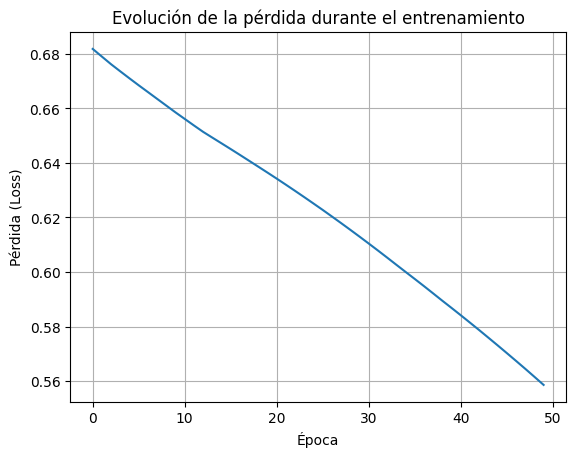

In [13]:
import matplotlib.pyplot as plt

plt.plot(loss_values)
plt.title("Evolución de la pérdida durante el entrenamiento")
plt.xlabel("Época")
plt.ylabel("Pérdida (Loss)")
plt.grid(True)
plt.show()


**NOTA**: Aquí podemos observar que se ha reducido considerablemente la pérdida

## Probamos al modelo una vez más, esta vez mejorado con el nuevo entrenamiento

In [14]:
model.eval() #Cambiamos a modo evaluación, no a entrenamiento

correct = 0
total = 0

with torch.no_grad(): #No son necesarios los gradientes, vamos a testear
    #Misma secuencia que en fitting, por lotes:
    for inputs, labels in test_loader:
        outputs = model(inputs)
        predicted = (outputs >= 0.5).float() #Aplicamos un umbral de 0.5
        labels = labels.view(-1, 1)# Mismo fix que antes
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

accuracy = correct / total #Precisión basado en la regla de laplace

print(f"Precisión del modelo: {accuracy * 100 : 2f}%")

Precisión del modelo:  50.000000%


## Conclusión

Los modelos de aprendizaje automático (Machine Learning) con datasets precarios o disminuidos suelen tender a equivocarse, pues no tienen mucha información a su alcance para lograr efectuar un buen rendimiento. 

No obstante, también hemos analizado el cómo influye que tanto entrenamiento tenga encima dicho modelo para poder ser cada vez mejor y poder aprender y auto ajustar esos errores con una cierta sutileza.

Este proyecto tuvo el objetivo de acercarnos a un primer contacto más serio con IA, aprendiendo:

- Cómo crear una arquitectura desde 0
- Cómo dividir un dataset en partes (Train, Test)
- Cómo pasar los datos del Training Set vía lotes para optimizar memoria
- Cómo realizar un entrenamiento y test adecuados y analizar su comportamiento

Que este sea el inicio para poder crear mejores modelos y poder llegar a complejidades mucho mas grandes.
